In [ ]:
%matplotlib inline

from sklearn import datasets, naive_bayes
import numpy as np

np.random.seed(1345)

In [ ]:
# Load the wine dataset
# Description => http://scikit-learn.org/stable/datasets/index.html#diabetes-dataset
wine = datasets.load_wine()
data = wine.data.copy()
target = wine.target.copy()

In [ ]:
# Split the data into training/testing sets
total_samples = wine.target.shape[0]
exclude = round(total_samples/3)
indices = np.arange(0, total_samples)
np.random.shuffle(indices)

idx_train = indices[:-exclude]
idx_test = indices[-exclude:]

assert not np.intersect1d(idx_test, idx_train).size

X_train = data[idx_train]
X_test = data[idx_test]

In [ ]:
# Split the targets into training/testing sets
y_train = target[idx_train]
y_test = target[idx_test]

print(y_test)

[0 1 2 2 2 0 0 0 1 2 1 0 1 1 1 0 1 1 0 1 0 2 0 1 2 2 2 2 0 0 2 2 1 1 0 1 1
 1 2 1 0 2 1 0 2 1 0 1 1 1 0 1 1 0 1 0 2 1 2]


In [ ]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [ ]:
# Create a naive bayes model with gaussian observations
nb = naive_bayes.GaussianNB()

# Train using training set
nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
# Predict using test set
y_pred = nb.predict(X_test)

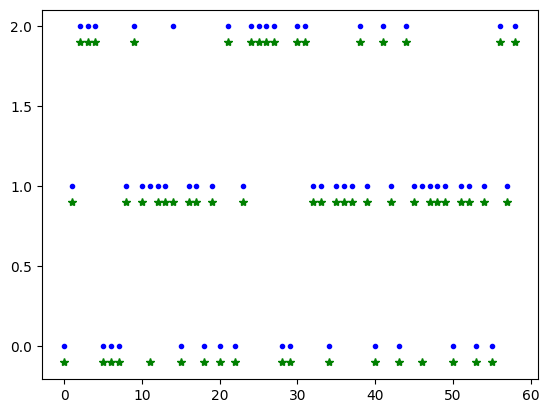

In [ ]:
# Plot outputs
plt.plot(y_test-0.1, 'g*')
plt.plot(y_pred, 'b.')
plt.show()

In [ ]:
# Evaluation
print(metrics.confusion_matrix(y_test, y_pred))
print("accuracy: %.2f" % metrics.accuracy_score(y_test, y_pred))

[[16  2  0]
 [ 0 24  1]
 [ 0  0 16]]
accuracy: 0.95


In [ ]:
# Calculate precision and recall (and f-score, a weighted average of precision and recall)
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, y_pred)
for c in np.unique(y_test):
  print("class %s, precision: %.2f, recall: %.2f, f_score: %.2f" % (c, precision[c], recall[c], fscore[c]))

class 0, precision: 1.00, recall: 0.89, f_score: 0.94
class 1, precision: 0.92, recall: 0.96, f_score: 0.94
class 2, precision: 0.94, recall: 1.00, f_score: 0.97


Naive Bayes using objects

In [ ]:
class myGaussianNB:
  def __init__(self):
    # Initialise the object
    self.nb = naive_bayes.GaussianNB()
  def fit(self, X_train, y_train):
    self.nb.fit(X_train, y_train)
  def predict(self, X_test):
    return self.nb.predict(X_test)

In [ ]:
# Evaluate as a binary classifier (i.e. oly consider class 0 vs. rest from the above)
target_binary = np.zeros(target.shape)
target_binary[target==0] = 1
y_train_bin = target_binary[idx_train]
y_test_bin = target_binary[idx_test]

myNB = myGaussianNB()
myNB.fit(X_train, y_train_bin)
y_pred_bin = myNB.predict(X_test)

print(metrics.confusion_matrix(y_test_bin, y_pred_bin))
print("accuracy: %.2f" % metrics.accuracy_score(y_test, y_pred))

[[40  1]
 [ 2 16]]
accuracy: 0.95


Implement my own version using Bayes theorem

In [ ]:
import math
import scipy.stats as stats

class myGaussianNB:
  def __init__(self):
    self.classes = []
    self.numObservations = 0

    self.class_prior = dict()
    self.class_mean = dict()
    self.class_std = dict()
    self.class_likelihood = dict()
    self.posteriors = []
    self.predictions = []
  def fit(self, X_train, y_train):
    self.classes = np.unique(y_train.astype(int))
    self.numObservations = X_train.shape[1]
    total = len(y_train)
    # train the model for each class
    for c in self.classes:
      # 1. calculate the prior => P(Class)
      self.class_prior[c] = np.sum(y_train==c) / total
      # 2. train a Gaussian model of the likelihood => P(Obs | Class)
      #    : calculate the mean and standard deviation of the classes!
      self.class_mean[c] = X_train[y_train==c].mean(0)
      self.class_std[c] = X_train[y_train==c].std(0)
  def predict(self, X_test):
    # 1. evaluate (log) likelihoods of test data for each class
    for c in self.classes:
      # There will be multiple gaussians that need to be combined using the naive assumption
      likelihood = 1
      for obs in np.arange(0, self.numObservations).astype(int):
        likelihood = likelihood * stats.norm.pdf(X_test[:, obs], self.class_mean[c][obs], self.class_std[c][obs])
      self.class_likelihood[c] = likelihood
      # 2. approximate the posterior using P(X | Y)P(Y)
      self.posteriors.append(self.class_prior[c] * self.class_likelihood[c])
    # 3. take the maximum posterior probability as our final class
    self.predictions = np.argmax(self.posteriors, 0)
    return self.predictions

myNB = myGaussianNB()
myNB.fit(X_train, y_train_bin)
y_pred_bin = myNB.predict(X_test)

print(metrics.confusion_matrix(y_test_bin, y_pred_bin))
print("accuracy: %.2f" % metrics.accuracy_score(y_test, y_pred))

[[40  1]
 [ 2 16]]
accuracy: 0.95
